In [1]:
from tqdm.notebook import tqdm
import time
import matplotlib.pyplot as plt
import numpy as np

from fooof.sim import gen_power_spectrum, gen_group_power_spectra
from fooof import FOOOF

from specparam import SpecParam # <- rust implementation

## Simulate

Simulate a variety of random periodic & aperiodic parameters, and noise levels.

In [2]:
def gen_params(freqs, seed):
    
    np.random.seed(seed)

    # Aperiodic
    ap_mode = np.random.choice(['lorentzian', 'linear'])
    exp = np.random.choice(np.linspace(1, 3, 11))
    
    if ap_mode == 'lorentzian':
        offset = np.random.choice(np.arange(1, 1100, 100))
        fk = np.random.choice(np.linspace(10, 50, 21))
        powers_ap = ((fk**exp)*offset) / (fk**exp + freqs**exp)
    elif ap_mode == 'linear':
        offset = np.random.choice(np.linspace(.1, 10, 21))
        powers_ap = 10**offset / freqs**exp
        
    powers_ap = np.log10(powers_ap)
    
    # Periodic
    n_osc = np.random.choice([0, 1, 2, 3])
    powers_pe = np.zeros(len(freqs))
    
    if n_osc > 0:
        ctr = np.array([
            np.random.choice(np.linspace(5, 10, 21)),
            np.random.choice(np.linspace(20, 30, 21)),
            np.random.choice(np.linspace(40, 50, 21))
        ])
        
        np.random.shuffle(ctr)
        
        for n in range(n_osc):
            hgt = np.random.choice(np.linspace(.1, .5, 21))
            wid = np.random.choice(np.linspace(1, 3, 21))
            powers_pe += hgt * np.exp(-(freqs-ctr[n])**2 / (2*wid**2))
            
    # Noise
    nlv = np.random.choice(np.linspace(.001, .1, 21))
    noise = np.random.normal(0, nlv, len(freqs))
    
    # Combine
    powers = 10**(powers_ap + powers_pe + noise)
    
    return powers, n_osc, ap_mode

## Fit

Fit each random simulation with the python and rust implementation.

In [3]:
n = 10000

freqs = np.arange(1, 101, dtype=float)
rsq = np.zeros((n, 2))
times = np.zeros((n, 2))
n_peak_diff = np.zeros((n, 2))

for i in tqdm(range(n), total=n):

    powers, n_osc, ap_mode = gen_params(freqs, i)
    
    if ap_mode == 'lorentzian':
        ap_mode_py = 'knee'
    elif ap_mode == 'linear':
        ap_mode_py = 'fixed'
    
    # Rust
    s = time.time_ns()
    sp = SpecParam(max_n_peaks=4, aperiodic_mode=ap_mode, peak_threshold=2)
    res = sp.fit(freqs, powers)
    e = time.time_ns()
    
    if len(res.peak_params_) == 1 and np.all(res.peak_params_[0] == 0.0):
        n_peak_diff[i, 1] = n_osc
    else:
        n_peak_diff[i, 1] = len(res.peak_params_) - n_osc
        
    rsq[i, 1] = np.corrcoef(np.log10(powers), res.powers_log_fit)[0][1] ** 2
    times[i, 1] = e-s
    
    # Python
    s = time.time_ns()
    fm = FOOOF(max_n_peaks=4, aperiodic_mode=ap_mode_py, verbose=False, peak_threshold=2)
    fm.fit(freqs, powers)
    e = time.time_ns()
    
    n_peak_diff[i, 0] = len(fm.peak_params_) - n_osc
    
    rsq[i, 0] = np.corrcoef(np.log10(powers), fm.fooofed_spectrum_)[0][1] ** 2
    times[i, 0] = e-s
    
    
times = times / 1e6 # to ms

  0%|          | 0/10000 [00:00<?, ?it/s]

## Results

Rust is faster but less accurate. This difference in accuracy is attributed to the python version's tendency to overfit peaks that aren't actually peaks, which also leads to a greater run time. The rust implementation also uses huber loss to de-weight outliers.

In [4]:
print('Time')
print()
print('Python mean: ', times[:, 0].mean(), ' ms')
print('Python std : ', times[:, 0].std(), ' ms')
print()
print('Rust   mean: ', times[:, 1].mean(), ' ms')
print('Rust   std : ', times[:, 1].std(), ' ms')

Time

Python mean:  11.177775399999998  ms
Python std :  6.832260863766462  ms

Rust   mean:  0.7391072999999999  ms
Rust   std :  0.6140511022599912  ms


In [5]:
print('R-squared')
print()
print('Python mean: ', rsq[:, 0].mean())
print('Python std : ', rsq[:, 0].std())
print()
print('Rust   mean: ', rsq[:, 1].mean())
print('Rust   std : ', rsq[:, 1].std())

R-squared

Python mean:  0.9834364809995247
Python std :  0.028364776624340664

Rust   mean:  0.9696592785355868
Rust   std :  0.04874370007250703


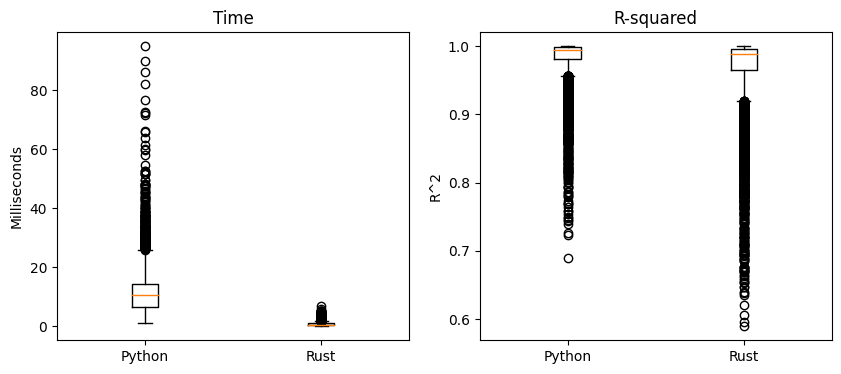

In [6]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4))

axes[0].boxplot(times[:, 0])
axes[0].boxplot(times[:, 1], positions=[2]);


axes[1].boxplot(rsq[:, 0])
axes[1].boxplot(rsq[:, 1], positions=[2]);

axes[0].set_title("Time")
axes[0].set_ylabel("Milliseconds")
axes[0].set_xticks([1, 2], ['Python', 'Rust'])

axes[1].set_title("R-squared")
axes[1].set_ylabel("R^2")
axes[1].set_xticks([1, 2], ['Python', 'Rust']);

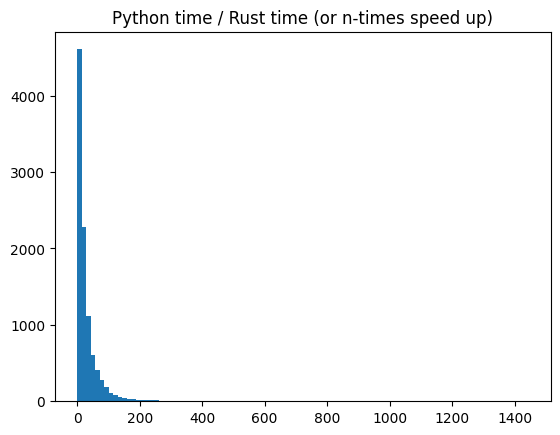

In [7]:
plt.title('Python time / Rust time (or n-times speed up)')
plt.hist(times[:, 0] / times[:, 1], bins=100);

In [8]:
print(f'Total runtime (python): {times[:, 0].sum().round(3)} ms')
print(f'Total runtime (rust)  : {times[:, 1].sum().round(3)} ms')

print(f'Mean Rust Speedup     : {(times[:, 0]/times[:, 1]).mean().round(3)}')

Total runtime (python): 111777.754 ms
Total runtime (rust)  : 7391.073 ms
Mean Rust Speedup     : 31.866


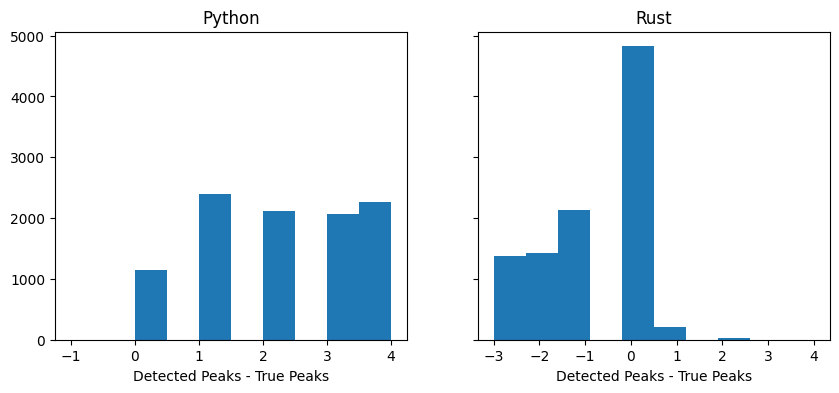

In [9]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

axes[0].hist(n_peak_diff[:, 0])

axes[1].hist(n_peak_diff[:, 1]);

axes[0].set_title("Python")
axes[1].set_title("Rust")

axes[0].set_xlabel("Detected Peaks - True Peaks")
axes[1].set_xlabel("Detected Peaks - True Peaks");